<a href="https://colab.research.google.com/github/SoYeoni621/mulcam/blob/master/LDA_Topicmodeling_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sentence_transformers

     |████████████████████████████████| 79 kB 7.6 MB/s 
     |████████████████████████████████| 4.0 MB 59.4 MB/s 
     |████████████████████████████████| 1.2 MB 71.1 MB/s 
     |████████████████████████████████| 77 kB 9.3 MB/s 
     |████████████████████████████████| 6.6 MB 58.2 MB/s 
     |████████████████████████████████| 596 kB 54.2 MB/s 
     |████████████████████████████████| 895 kB 62.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=55486a44a5fb601d7b565fdbd719064df37c1ad793d7550b297a450be94d97c9
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [1]:
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer,  SentencesDataset, LoggingHandler, losses, util, InputExample, models
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
import math
import numpy as np

In [4]:
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [5]:
train_batch_size = 16

model_name='/content/drive/MyDrive/프로젝트/kpfbert'
word_embedding_model = models.Transformer(model_name)
# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

Some weights of the model checkpoint at /content/drive/MyDrive/프로젝트/kpfbert were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/프로젝트/kpfbert and are newly initialized: ['bert.pooler.de

In [6]:
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [7]:
logging.info("Read AllNLI train dataset")

2022-04-19 04:15:04 - Read AllNLI train dataset


In [8]:
label2int = {"contradiction": 0, "entailment": 1, "neutral": 2}
train_samples = []

In [9]:
with open('/content/drive/MyDrive/프로젝트/snli_1.0_train.ko.tsv', "rt", encoding="utf-8") as fIn:
    lines = fIn.readlines()
    print(lines)
    for line in lines:
        s1, s2, label = line.split('\t')
        label = label2int[label.strip()]
        train_samples.append(InputExample(texts=[s1, s2], label=label))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
train_dataset = SentencesDataset(train_samples, model=model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=len(label2int))

2022-04-19 04:15:18 - Softmax loss: #Vectors concatenated: 3


In [11]:
#Read STSbenchmark dataset and use it as development set
logging.info("Read STSbenchmark dev dataset")
dev_samples = []

2022-04-19 04:15:22 - Read STSbenchmark dev dataset


In [12]:
with open('/content/drive/MyDrive/프로젝트/tune_dev.tsv', 'rt', encoding='utf-8') as fIn:
    lines = fIn.readlines()
    for line in lines:
        s1, s2, score = line.split('\t')
        score = score.strip()
        score = float(score) / 5.0
        dev_samples.append(InputExample(texts= [s1,s2], label=score))

In [13]:
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, batch_size=train_batch_size, name='sts-dev')

In [14]:
num_epochs = 1

warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

2022-04-19 04:15:28 - Warmup-steps: 3439


In [15]:
import torch

print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:1.10.0+cu111
cuda version: 11.1
cudnn version:8005


In [15]:
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=dev_evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
#           output_path=model_save_path
          )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/34385 [00:00<?, ?it/s]

2022-04-19 04:19:07 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 1000 steps:
2022-04-19 04:19:11 - Cosine-Similarity :	Pearson: 0.7025	Spearman: 0.7030
2022-04-19 04:19:11 - Manhattan-Distance:	Pearson: 0.6957	Spearman: 0.7006
2022-04-19 04:19:11 - Euclidean-Distance:	Pearson: 0.6953	Spearman: 0.7001
2022-04-19 04:19:11 - Dot-Product-Similarity:	Pearson: 0.4150	Spearman: 0.4108
2022-04-19 04:22:38 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 2000 steps:
2022-04-19 04:22:43 - Cosine-Similarity :	Pearson: 0.6971	Spearman: 0.7133
2022-04-19 04:22:43 - Manhattan-Distance:	Pearson: 0.6987	Spearman: 0.7069
2022-04-19 04:22:43 - Euclidean-Distance:	Pearson: 0.6960	Spearman: 0.7054
2022-04-19 04:22:43 - Dot-Product-Similarity:	Pearson: 0.5600	Spearman: 0.5690
2022-04-19 04:26:14 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset in epoch 0 after 3000 steps:
2022-04-19 04:26:18 - Cosine-

KeyboardInterrupt: ignored

In [7]:
train_batch_size = 16
num_epochs = 4
model_save_path = '/content/drive/MyDrive/프로젝트/output/kpfSBERT_nli'

In [8]:
logging.info("Read STSbenchmark train dataset")

In [9]:
train_samples = []
dev_samples = []
test_samples = []
with open('/content/drive/MyDrive/프로젝트/tune_dev.tsv', 'rt', encoding='utf-8') as fIn:
    lines = fIn.readlines()
    for line in lines:
        s1, s2, score = line.split('\t')
        score = score.strip()
        score = float(score) / 5.0
        dev_samples.append(InputExample(texts= [s1,s2], label=score))

with open('/content/drive/MyDrive/프로젝트/tune_test.tsv', 'rt', encoding='utf-8') as fIn:
    lines = fIn.readlines()
    for line in lines:
        s1, s2, score = line.split('\t')
        score = score.strip()
        score = float(score) / 5.0
        test_samples.append(InputExample(texts= [s1,s2], label=score))

with open('/content/drive/MyDrive/프로젝트/tune_train.tsv', 'rt', encoding='utf-8') as fIn:
    lines = fIn.readlines()
    for line in lines:
        s1, s2, score = line.split('\t')
        score = score.strip()
        score = float(score) / 5.0
        train_samples.append(InputExample(texts= [s1,s2], label=score))

train_dataset = SentencesDataset(train_samples, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)

In [10]:
# Development set: Measure correlation between cosine score and gold labels
logging.info("Read STSbenchmark dev dataset")
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')

warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

In [11]:
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

In [12]:
model = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
test_evaluator(model, output_path=model_save_path)

0.8243972777241606

In [13]:
# TEST2 : Clustering with k-means

model_path = model_save_path

model = SentenceTransformer(model_path)

# Corpus with example sentences
corpus = ['한 남자가 음식을 먹는다.',
          '한 남자가 빵 한 조각을 먹는다.',
          '그 여자가 아이를 돌본다.',
          '한 남자가 말을 탄다.',
          '한 여자가 바이올린을 연주한다.',
          '두 남자가 수레를 숲 속으로 밀었다.',
          '한 남자가 담으로 싸인 땅에서 백마를 타고 있다.',
          '원숭이 한 마리가 드럼을 연주한다.',
          '치타 한 마리가 먹이 뒤에서 달리고 있다.',
          '한 남자가 파스타를 먹는다.',
          '고릴라 의상을 입은 누군가가 드럼을 연주하고 있다.',
          '치타가 들판을 가로 질러 먹이를 쫓는다.']

corpus_embeddings = model.encode(corpus)

# Then, we perform k-means clustering using sklearn:
from sklearn.cluster import KMeans

num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['원숭이 한 마리가 드럼을 연주한다.', '고릴라 의상을 입은 누군가가 드럼을 연주하고 있다.']

Cluster  2
['한 남자가 음식을 먹는다.', '한 남자가 빵 한 조각을 먹는다.', '한 남자가 파스타를 먹는다.']

Cluster  3
['치타 한 마리가 먹이 뒤에서 달리고 있다.', '치타가 들판을 가로 질러 먹이를 쫓는다.']

Cluster  4
['한 남자가 말을 탄다.', '두 남자가 수레를 숲 속으로 밀었다.', '한 남자가 담으로 싸인 땅에서 백마를 타고 있다.']

Cluster  5
['그 여자가 아이를 돌본다.', '한 여자가 바이올린을 연주한다.']



In [14]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/프로젝트/newsresult.xlsx')

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [15]:
data = df[['일자', '본문']]

In [16]:
data

,일자,본문
0,20220317,[머니투데이 정인지 기자] \n \n\n CJ올리브영(이하 올리브영)은 오는 18일...
1,20220317,호반그룹이 코로나19 장기화로 지친 전국 현장 노무자들에 격려 물품을 전달했다.\n...
2,20220317,[아시아경제 이창환 기자] #. 서울 사는 40대 초반의 직장인 A씨는 요즘 보험상...
3,20220317,[머니투데이 배규민 기자] \n삼성엔지니어링이 환경 분야 전문가인 사외이사를 선임하...
4,20220317,로보테크가 자체 개발한 쿠킹 로봇 '쿡봇셰프(COOKBOT CHEF)'를 오프라인 ...
...,...,...
19995,20220307,제20대 대통령선거를 이틀 앞둔 7일 오후 9시까지 전국에서 20만명에 달하는 코로...
19996,20220307,[KBS 창원]\n [앵커]\n\n 우크라이나를 침공한 러시아에 대한 미국의 경제 ...
19997,20220307,"‘기술자 15명에 현장 95개’ 등 부적격업체, 서울 지난해 58곳 경기 2년간 2..."
19998,20220307,[사진 = 아주경제 DB] \n \n 확진 격리자 투표 외출시간 오후 5시50분...


In [17]:
data1 = data.loc[data['일자']==20220317]

In [48]:
print(data1.본문)

0       [머니투데이 정인지 기자] \n \n\n CJ올리브영(이하 올리브영)은 오는 18일...
1       호반그룹이 코로나19 장기화로 지친 전국 현장 노무자들에 격려 물품을 전달했다.\n...
2       [아시아경제 이창환 기자] #. 서울 사는 40대 초반의 직장인 A씨는 요즘 보험상...
3       [머니투데이 배규민 기자] \n삼성엔지니어링이 환경 분야 전문가인 사외이사를 선임하...
4       로보테크가 자체 개발한 쿠킹 로봇 '쿡봇셰프(COOKBOT CHEF)'를 오프라인 ...
                              ...                        
1601    삼성전자가 사업간 경계를 뛰어넘는 통합 시너지를 확대하고, 미래 신성장 동력을 발굴...
1602    한국 화장품(K-뷰티)은 혁신과 창의성은 앞서 있으나 상대적으로 기초 소재 생산성 ...
1603    부천시가 경기지역에서 가장 적은 지역화폐 인센티브를 지급하는 것으로 나타나 시민들의...
1604    LH(한국토지주택공사) 인천지역본부는 16일 3층 대회의실에서 환경ㆍ사회ㆍ지배구조(...
1605    “하루가 멀다하고 치솟으니 조금이라도 싼 곳을 찾을 수밖에 없네요” \n\n15일 ...
Name: 본문, Length: 1606, dtype: object


In [18]:
corpus = []
for i in range(len(data1)):
    sent = data1['본문'][i]
    corpus.append(sent)

In [54]:
type(corpus)

list

In [19]:
model_path = model_save_path

model = SentenceTransformer(model_path)

corpus_embeddings = model.encode(corpus)

# Then, we perform k-means clustering using sklearn:
from sklearn.cluster import KMeans

num_clusters = 11
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
["[머니투데이 정인지 기자] \n \n\n CJ올리브영(이하 올리브영)은 오는 18일부터 열흘간 서울시 마포구 연남동에 위치한 복합문화공간 '연남방앗간'에서 클린뷰티 팝업스토어를 운영한다고 17일 밝혔다. 올리브영이 자체 캠페인을 매장이 아닌 외부 공간에서 전개하는 것은 이번이 처음이다.\n\n팝업스토어는 '나 지구 동물을 지키는 다정한 힘, 다정력(力) 하우스'..", "로보테크가 자체 개발한 쿠킹 로봇 '쿡봇셰프(COOKBOT CHEF)'를 오프라인 박람회에서 처음 공개한다.\n\n로보테크(대표 강삼태)는 오는 24~26일 서울 코엑스에서 열리는 'IFS 프랜차이즈 창업박람회 2022 서울' 두산로보틱스 부스에서 '쿡봇셰프' 2종을 소개한다고 17일 밝혔다.\n\n'쿡봇셰프'는 각종 튀김류에서 한식, 중식, 일식, 양식 등 ..", "SK스토아는 오는 19일부터 4주간 매주 토요일 패션 전문프로그램 '패션 라스테이션'을 새롭게 선보인다고 17일 밝혔다.\n\n\n\n패션 라스테이션에서는 스타일링 콘셉트를 제안하고 체형별 맞춤형 코디, 트렌드에 맞는 활용 팁 등 제품과 관련한 상세한 설명을 고객에게 제공한다.\n\n\n\n첫 방송은 '헤스티지의 22년 SS 양가죽 스타디움 재킷', '어썸핏 소프트엔..", '5천 달러였던 국내 면세점 구매 한도가 내일부터 폐지됩니다. \n\n기획재정부는 관세법 시행규칙 개정에 따라 내일부터 해외로 출국하는 내국인은 한도 제한 없이 면세점에서 물품을 구매할 수 있다고 밝혔습니다.\n\n면세점 구매 한도가 사라지는 건 1979년 제도 신설 이후 43년 만입니다. \n\n다만 술과 담배, 향수를 제외한 여행자의 휴대품 면세 한도는 6백 달..', '신속항원도 ‘오픈 런’ ‘샤이 오미크론’까지 급증', '글로벌 향기마케팅 전문기업 ㈜아이센트(iSCENT, 대표 최아름)가 프랑스 클래식 브랜드 ‘세인트제임스(Saint James)’와 함께 브랜드고유의 시그니쳐향을 활용하여 분위기센세이션을 통한 감각체험을 강화시키

In [20]:
clustered_sentences[0]

["[머니투데이 정인지 기자] \n \n\n CJ올리브영(이하 올리브영)은 오는 18일부터 열흘간 서울시 마포구 연남동에 위치한 복합문화공간 '연남방앗간'에서 클린뷰티 팝업스토어를 운영한다고 17일 밝혔다. 올리브영이 자체 캠페인을 매장이 아닌 외부 공간에서 전개하는 것은 이번이 처음이다.\n\n팝업스토어는 '나 지구 동물을 지키는 다정한 힘, 다정력(力) 하우스'..",
 "로보테크가 자체 개발한 쿠킹 로봇 '쿡봇셰프(COOKBOT CHEF)'를 오프라인 박람회에서 처음 공개한다.\n\n로보테크(대표 강삼태)는 오는 24~26일 서울 코엑스에서 열리는 'IFS 프랜차이즈 창업박람회 2022 서울' 두산로보틱스 부스에서 '쿡봇셰프' 2종을 소개한다고 17일 밝혔다.\n\n'쿡봇셰프'는 각종 튀김류에서 한식, 중식, 일식, 양식 등 ..",
 "SK스토아는 오는 19일부터 4주간 매주 토요일 패션 전문프로그램 '패션 라스테이션'을 새롭게 선보인다고 17일 밝혔다.\n\n\n\n패션 라스테이션에서는 스타일링 콘셉트를 제안하고 체형별 맞춤형 코디, 트렌드에 맞는 활용 팁 등 제품과 관련한 상세한 설명을 고객에게 제공한다.\n\n\n\n첫 방송은 '헤스티지의 22년 SS 양가죽 스타디움 재킷', '어썸핏 소프트엔..",
 '5천 달러였던 국내 면세점 구매 한도가 내일부터 폐지됩니다. \n\n기획재정부는 관세법 시행규칙 개정에 따라 내일부터 해외로 출국하는 내국인은 한도 제한 없이 면세점에서 물품을 구매할 수 있다고 밝혔습니다.\n\n면세점 구매 한도가 사라지는 건 1979년 제도 신설 이후 43년 만입니다. \n\n다만 술과 담배, 향수를 제외한 여행자의 휴대품 면세 한도는 6백 달..',
 '신속항원도 ‘오픈 런’ ‘샤이 오미크론’까지 급증',
 '글로벌 향기마케팅 전문기업 ㈜아이센트(iSCENT, 대표 최아름)가 프랑스 클래식 브랜드 ‘세인트제임스(Saint James)’와 함께 브랜드고유의 시그니쳐향을 활용하여 분위기센세이션을 통한 감각체험을 강화시키는 향기마케

In [60]:
!pip install kss

     |████████████████████████████████| 42.4 MB 273 kB/s 
     |████████████████████████████████| 175 kB 6.1 MB/s 
  Created wheel for kss: filename=kss-3.4.2-py3-none-any.whl size=42448069 sha256=aaf249d5fd78cd84c0bac4a8b33ae02ee2c2741cb739a1ffffd6fe7f1cb8f09f
  Stored in directory: /root/.cache/pip/wheels/ef/22/aa/6399b60516a067ec97fa6599fb2d472aeb25e3f9ee6dae3224
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=f776fd407caecad1a13a06f6317f8fc8383f8598dfef96a6ab9c5114d2019471
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built kss emoji


In [61]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-04-19 05:35:43--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-04-19 05:35:44--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7bed34ff91021df8e9e972c75f.dl.dropboxusercontent.com/cd/0/get/Bjo7wVjMTQeaAbvAf_IQUDOWgW5bbYV9ziENyCZSMbt3G1_MMMRd5nEhrsGQOGRrJP7b70OJhyBjeeJpIMLkb_KGQe0-jgn8M_9t8JnKwtlHxhnMW_YNdkmrKV-wb8trdOhPOwcSU4ahniTF9J7Tq0xnPJDOlCwC50VtA5KzJPUPyifQ7Ix29n66xQGz31zbl4Q/file?dl=1# [following]
--2022-04-19 05:35:44--  https://uc7bed34ff91021df8e9e972c75f.dl.dropboxusercontent.com/cd/0/g

In [21]:
from collections import Counter
from konlpy.tag import Okt
import kss

In [64]:
clustered_sentences[0][:10]

['강원도는 러시아의 우크라이나 침공과 동해안 산불로 피해를 본 중소기업에 경영안정자금 200억원을 긴급 지원한다고 17일 밝혔다. \n \n도에 따르면 도내 러시아와 우크라이나 수출업체는 140여개로 수출금액은 5700만달러다. 이는 도내 전체 수출액의 1% 정도지만 도민의 실생활과 밀접한 품목이 많고, 영세한 중소기업은 경영에 타격을 입을 수밖에 없다. \n..',
 "원자재 가격 폭등과 러시아발(發) 공급망 불안이 그렇잖아도 오르는 자동차 가격을 한층 부채질 하고 있다. 차량용 반도체 부족 상황이 장기화하는 가운데 글로벌 자동차 시장에 본격적인 '카플레이션(카+인플레이션)' 현상이 불어닥치는 것 아니냐는 우려가 나온다. \n \n17일 업계에 따르면 차값 인상을 주도하는 건 테슬라다. 일론 머스크 최고경영자(CEO)가 ..",
 '[앵커]\n\n 코로나19와 우크라이나 전쟁으로 가중되는 물류대란은 일본의 동물원에도 직접적인 타격을 입히고 있습니다.\n\n [리포트]\n\n 일본 에히메현의 한 동물원.\n\n 150여 종류, 650여 마리의 동물을 기르고 있습니다.\n\n 때문에 매일 방대한 양의 사료가 소비되는데요.\n\n 가장 많이 소비하는 사료는 마른 풀로, 일 년에 100여 톤 정도 소비됩니다...',
 '[앵커]\n\n 우크라이나 전쟁으로 국제 밀 가격도 가파르게 상승하고 있습니다.\n\n [리포트]\n\n 우크라이나와 러시아는 전 세계 밀의 3분의 1을 공급하는 유럽의 곡창입니다.\n\n 하지만 러시아의 침공으로 국제 밀 가격이 요동치고 있습니다.\n\n 전쟁 전과 비교했을 때 40% 가까이 급증했습니다.\n\n [프릭크/유엔 세계식량계획 베를린 지국장 : "이 분쟁이 오..',
 "[머니투데이 정혜인 기자] [UAE 사우디 실세와 '에너지 시장 안정화' 회담 \n영국 존재감 부각, 중동과의 관계 강화 목적 평가]\n\n 러시아의 우크라이나 침공 사태에 따른 서방의 경제제재에 세계 에너지 시장이 요동치는 가운데, 보리스 존슨 영국 총리가 주요 산

In [63]:
len(clustered_sentences[0])

225

In [64]:
okt = Okt()
news_list=[]

#형태소 분석

for i in range(len(clustered_sentences[0])):
    sentence_list = kss.split_sentences(clustered_sentences[0][i])
    nouns_list = []   
    for sentence in sentence_list:
        nouns = okt.pos(sentence)
        for noun, pos in nouns:
            if pos == 'Noun':
                nouns_list += [noun]

    news_list.append(nouns_list)

In [61]:
tmp = kss.split_sentences(clustered_sentences[0][0])
nouns_list = []
for sent in tmp:
    nouns = okt.pos(sent)
    for i, j in nouns:
        if j == "Noun":
            nouns_list += [i]

nouns_list

['머니투데이',
 '정인지',
 '기자',
 '올리브영',
 '이하',
 '올리브영',
 '은',
 '열흘',
 '서울시',
 '마포구',
 '연남동',
 '위치',
 '복합',
 '문화',
 '공간',
 '연남',
 '방앗간',
 '클린',
 '뷰티',
 '팝업',
 '스토어',
 '운영',
 '올리브영',
 '자체',
 '캠페인',
 '매장',
 '외부',
 '공간',
 '전개',
 '것',
 '이번',
 '처음',
 '팝업',
 '스토어',
 '나',
 '지구',
 '동물',
 '힘',
 '다정',
 '하우스']

In [66]:
from gensim.corpora import Dictionary

dct = Dictionary(news_list) #형태소 분석을 통해 만든 명사 리스트를 사전으로 생성

In [67]:
corpus = [dct.doc2bow(text) for text in news_list] #코퍼스 생성

In [68]:
import gensim

NUM_TOPICS = 5 #토픽의 개수를 지정하여 진행하는 경우

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dct, iterations=50)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [69]:
from gensim.models import CoherenceModel

#Coherence score : 값이 클수록 정확한 데이터
#Perplexity score : 값이 작을수록 정확한 데이터

In [70]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

#토픽 개수에 따라 Coherence score, Perplexity score 값을 반복 도출하는 사용자 정의 함수

    coherence_values = []
    perplexity_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, iterations=50, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(ldamodel.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_values

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(El

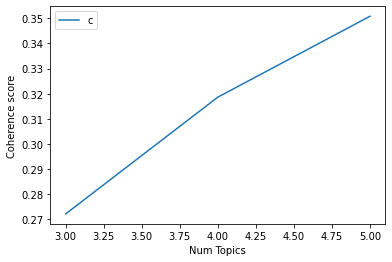

In [71]:
import matplotlib.pyplot as plt

Ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dct, iterations=50)
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=dct, corpus=corpus, texts=news_list, start=3, limit=6, step=1)
limit=6; start=3; step=1;

#토픽의 개수를 3~5개로 제한하여 Coherence score, Perplexity score 값을 연속적으로 도출
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

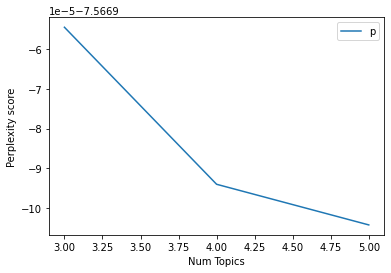

In [72]:
x = range(start, limit, step)

plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [73]:
!pip install pyLDAvis

ERROR: Operation cancelled by user


In [74]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
ldamodel = model_list[2] #Coherence score 값이 가장 크고, Perplexity score 값이 가장 작은 점
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dct, sort_topics=False)
pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, '/content/drive/MyDrive/프로젝트/Topic.html')
topics = ldamodel.print_topics()
for topic in topics:

    print(topic)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


(0, '0.008*"오프라인" + 0.007*"롯데" + 0.007*"고객" + 0.007*"백화점" + 0.006*"등" + 0.006*"기자" + 0.006*"를" + 0.006*"점" + 0.006*"판매" + 0.006*"할인"')
(1, '0.018*"서비스" + 0.014*"프리미엄" + 0.013*"구독" + 0.012*"출시" + 0.011*"유튜브" + 0.011*"쿠폰" + 0.008*"제공" + 0.008*"구매" + 0.008*"등" + 0.007*"수"')
(2, '0.013*"애플" + 0.011*"연" + 0.011*"건조" + 0.010*"서울" + 0.010*"갤러리" + 0.009*"백화점" + 0.009*"명동" + 0.009*"아트" + 0.008*"금리" + 0.007*"신세계"')
(3, '0.011*"서비스" + 0.009*"브랜드" + 0.009*"미래에셋" + 0.007*"결제" + 0.007*"매장" + 0.006*"스포츠" + 0.006*"기자" + 0.005*"제품" + 0.005*"수" + 0.005*"점포"')
(4, '0.016*"등" + 0.013*"상품" + 0.013*"유럽" + 0.011*"여행" + 0.009*"판매" + 0.009*"기자" + 0.008*"롯데" + 0.008*"홈쇼핑" + 0.008*"고객" + 0.008*"격리"')
